In [51]:
# print out each line in the input cell not only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# expand the cell width to 100% of t 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [59]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List 

In [53]:
def _initialize_julia_sets(constant_c, x_start, x_end, y_start, y_end):
    return {
        'constant_c': constant_c,
        'x_start': x_start,
        'x_end': x_end,
        'y_start': y_start,
        'y_end': y_end
    }

In [54]:
def _initialize_matrix(x_start, x_end, y_start, y_end, scaling_matrix):
    matrix_complex_numbers = []

    for col in np.arange(x_start, x_end + 1, 1 / scaling_matrix):
        col_list = []

        for row in np.arange(y_start, y_end + 1, 1 / scaling_matrix):
            col_list.append(complex(col, row))
        matrix_complex_numbers.append(col_list)

    return matrix_complex_numbers

In [55]:
@njit
def validate_point(complex_number, constant_c):
    run = 200
    while -100 < complex_number.real < 100 and run > 0:
        complex_number = complex_number * complex_number + constant_c
        run -= 1

    return run

In [56]:
@njit
def change_matrix(matrix_complex_numbers, x_start, x_end, y_start, y_end, constant, matrix_scaling):
    final_matrix = []

    for row in range((y_end - y_start) * matrix_scaling + 1):
        rows = []
        for col in range((x_end - x_start) * matrix_scaling + 1):
            rows.append(validate_point(matrix_complex_numbers[col][row], constant))
        final_matrix.append(rows)

    return final_matrix

In [57]:
def _create_picture(final_matrix):
    plt.imshow(final_matrix)
    plt.axis('off')
    plt.axis('tight')
    plt.set_cmap('seismic')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.show()

Working...
Calculation time: 6.58 Seconds!


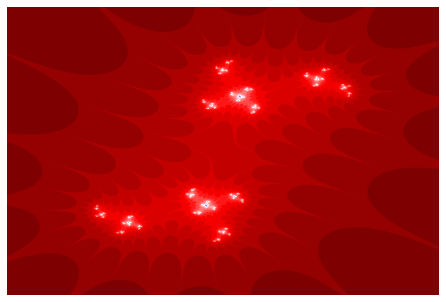

In [63]:
scaling = 500
t0 = time.time()
print('Working...')

setup = _initialize_julia_sets(complex(0.39, 0.99), -2, 2, -2, 2)

matrix = _initialize_matrix(setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'], scaling)

converter_list = List()

for index in matrix:
    converter_list.append(index)
    
matrix = change_matrix(converter_list, setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'],
                       setup['constant_c'], scaling)

t1 = time.time()
print('Calculation time: ' + str(round(t1 - t0, 2)) + " Seconds!")
_create_picture(matrix)